# Citation Network Demo

This notebook applies InfoFlow onto a citation network and performs further analysis, as an illustrative example of InfoFlow usage.

## Network

We use the network provided by Vladimir Batagelj and Andrej Mrvar (2006) Pajek datasets.
[ URL: http://vlado.fmf.uni-lj.si/pub/networks/data/ ], who provided the Pajek net file for the "Lederberg" citations in http://www.garfield.library.upenn.edu/histcomp/index.html, with 8843 nodes and 41601 edges.

## Below are configuration parameters

In [1]:
# parameters related to Java
java_conf = {
    "dir": r'/home/felix/Work/Community Detection/InfoFlow',
    "jar_name": "infoflow",
    "scala_version": "2.11",
    "infoflow_version": "0.2.6"
}

In [2]:
# parameters required in InfoFlow config file
infoflow_config = {
    "Graph": 'Notebooks/citation.net',
    "spark configs": {
        "Master": "local[*]",
        "num executors": "1",
        "executor cores": "8",
        "driver memory": "60G",
        "executor memory": "60G"
    },
    "PageRank": {
        "tele": 0.15,
        "error threshold factor": 20
    },
    "Community Detection": {
        "name": "InfoFlow",
        "merge direction": "symmetric",
        "merge reset": False,
        "merge nonedge": False
    },
    "log": {
        "log path": "Output/log.txt",
        "Parquet path": '',
        "RDD path": '',
        "txt path": "Output/vertex.txt",
        "Full Json path": '',
        "Reduced Json path": "Output/graph.json",
       "debug": False
    }
}

## Set up environment and run InfoFlow

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from ipywidgets import widgets, interact

In [4]:
def chDir( java_conf ):
    """Change to InfoFlow directory"""
    if not os.path.exists( java_conf['dir'] ):
        raise RuntimeError("Working directory {} does not exist".format(java_conf['dir']))

    os.chdir( java_conf['dir'] )

    if os.getcwd() != java_conf['dir'] and os.getcwd()+'/' != java_conf.infoflow_dir:
        raise RuntimeError("Working directory {} does not exist".format(java_conf['dir']))
chDir(java_conf)

In [5]:
def runInfoFlow( java_conf, infoflow_config ):
    """Set up config file and runs InfoFlow"""

    infoflow_config_string = json.dumps( infoflow_config, indent=2 )
    notebook_json = "notebook.json"
    with open(notebook_json,"w") as config_handle:
        config_handle.write(infoflow_config_string)

    jar = "{}_{}-{}.jar".format( java_conf['jar_name'], java_conf['scala_version'], java_conf['infoflow_version'] )
    %time os.system("spark-submit target/scala-{}/{} {}".format( java_conf['scala_version'], jar, "notebook.json" ))
runInfoFlow( java_conf, infoflow_config )

CPU times: user 55 µs, sys: 7.29 ms, total: 7.34 ms
Wall time: 44.3 s


## Display log file

In [6]:
!cat {infoflow_config['log']['log path']}

Fri Feb 22 21:19:42 EST 2019: Running InfoFlow, version: 0.2.6
Fri Feb 22 21:19:42 EST 2019: Driver memory/Java heap size: 910 Mb
Fri Feb 22 21:19:42 EST 2019: Spark version: 2.3.0
Fri Feb 22 21:19:42 EST 2019: Spark configurations:
Fri Feb 22 21:19:42 EST 2019: spark.executor.instances: 1
Fri Feb 22 21:19:42 EST 2019: spark.master: local[*]
Fri Feb 22 21:19:42 EST 2019: spark.driver.memory: 60G
Fri Feb 22 21:19:42 EST 2019: spark.executor.memory: 60G
Fri Feb 22 21:19:42 EST 2019: spark.submit.deployMode: client
Fri Feb 22 21:19:42 EST 2019: spark.app.name: InfoFlow
Fri Feb 22 21:19:42 EST 2019: spark.jars: file:/home/felix/Work/Community%20Detection/InfoFlow/target/scala-2.11/infoflow_2.11-0.2.6.jar
Fri Feb 22 21:19:42 EST 2019: spark.executor.cores: 8
Fri Feb 22 21:19:42 EST 2019: Reading Notebooks/citation.net
Fri Feb 22 21:19:42 EST 2019: Finished reading from disk; parallelizing...
Fri Feb 22 21:19:45 EST 2019: Read in network with 8843 nodes and 41601 edges
Fri Feb 22 21:19:45 ES

### So InfoFlow partitions WordNet into some 3000 modules, from some 9000 modules, representing around a threefold reduction in nodes. What does that signify?

### First, plot the reduced graph, where each node is a community. To ease visualization we only plot the nodes with ergodic frequency up to some threshold.

In [7]:
def getGraph( infoflow_config ):
    """get community graph"""
    with open( infoflow_config['log']['Reduced Json path'] ) as graphHandle:
        graphJS = json.load( graphHandle )
    return graphJS
graphJS = getGraph( infoflow_config )

In [8]:
def readNodesLinks( graphJS ):
    """Read Json graph for further statistics, for cells below"""
    nodes = pd.io.json.json_normalize( graphJS['nodes'] )
    links = pd.io.json.json_normalize( graphJS['links'] )
    return nodes, links
nodes, links = readNodesLinks( graphJS )
graph = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )

In [9]:
def plotGraph( threshold_size ):
    """
    Plots the InfoFlow output graph, where each node is a module
    The node size indicates the ergodic frequency of the module

    :param str threshold_size: minimum ergodic frequency for the module to be shown

    """

    custom_color_map = plt.get_cmap('Spectral')

    sub_nodes = []
    sub_nodes_size = []
    sub_nodes_color = []
    for i in range( len(graphJS['nodes']) ):
        if( float(graphJS['nodes'][i]['size']) >= float(threshold_size) ):
            sub_nodes.append( graphJS['nodes'][i]['name'] )
            sub_nodes_size.append(float( graphJS['nodes'][i]['size'] ) *30000)
            sub_nodes_color.append( len(sub_nodes_color) )

    map( lambda x: custom_color_map( float(x)/float(len(sub_nodes_color)) ), sub_nodes_color )
    
    filteredGraph = graph.subgraph( sub_nodes )

    plt.figure( figsize=[20,10], clear=True )
    nx.draw_networkx_nodes( filteredGraph, pos=nx.kamada_kawai_layout(filteredGraph), nodelist=filteredGraph.nodes, \
                           node_size=sub_nodes_size, \
                           alpha=0.5, node_color=sub_nodes_color )
    nx.draw_networkx_labels( filteredGraph, pos=nx.kamada_kawai_layout(filteredGraph), nodelist=filteredGraph.nodes )
    nx.draw_networkx_edges( filteredGraph, pos=nx.kamada_kawai_layout(filteredGraph), edgelist=filteredGraph.edges, alpha=0.2 )
    plt.xticks([])
    plt.yticks([])
interact( plotGraph, threshold_size=str(1.0/len(nodes)) );

interactive(children=(Text(value='0.0003059039461609055', description='threshold_size'), Output()), _dom_class…

## It looks like the big modules are all-connected. How to make sense of it?

### Check the modular statistics:

In [10]:
def countUsefulNodes( graph, nodes, links ):
    """Counts number of total modules, number of small modules, number of "useful" modules """
    node_sizes = pd.to_numeric( nodes['size'] )
    node_counts = pd.to_numeric( nodes['count'] )

    singleton_modules = nodes[ node_counts==1 ]
    size_threshold = 1.0/len(nodes)
    small_modules = nodes[ node_sizes<=size_threshold ]
    singleton_and_small_modules = nodes[ (node_counts==1) | (node_sizes<=size_threshold) ]
    significant_modules = nodes[ (node_counts>1) & (node_sizes>size_threshold) ]
    significant_module_size = pd.to_numeric( significant_modules['size'] )
    significant_module_count = pd.to_numeric( significant_modules['count'] )
    connected_components = nx.number_weakly_connected_components(graph)

    print("Total number of modules: {}".format( len(nodes) ))
    print("Number of connected components: {}".format( connected_components ))
    print("")

    print("Modules with only one node: {}".format( len(singleton_modules) ))
    print("Modules with small ergodic frequency: {}".format( len(small_modules) ))
    print("Modules with only one node or has small ergodic frequency: {}".format( len(singleton_and_small_modules) ))
    print("Number of modules that are not small and not singleton: {}".format( len(significant_modules) ))
    print("")

    print("Average number of significant modules per connected component: {}".format( \
        (len(nodes) -len(singleton_and_small_modules))/connected_components ))
    print("Average number of insignificant modules per significant one: {}".format( \
        len(singleton_and_small_modules)/len(significant_modules) ))
    print("Mean number of nodes per significant module: {}".format( \
        significant_module_count.mean() ))
    print("Mean ergodic frequency per significant module: {}".format( \
        significant_module_size.mean() ))
    print("Total ergodic frequency of significant modules: {:2.2%}".format( \
        significant_module_size.sum() ))
countUsefulNodes( graph, nodes, links )

Total number of modules: 3269
Number of connected components: 554

Modules with only one node: 2342
Modules with small ergodic frequency: 2656
Modules with only one node or has small ergodic frequency: 2656
Number of modules that are not small and not singleton: 613

Average number of significant modules per connected component: 1.1064981949458483
Average number of insignificant modules per significant one: 4.33278955954323
Mean number of nodes per significant module: 9.445350734094617
Mean ergodic frequency per significant module: 0.0012594649579703737
Total ergodic frequency of significant modules: 77.21%


### Looking at these numbers, there are many disjoint subgraphs (connected components). On average, each disjoint subgraph has 6 communities. Out of these communities, most are "insignificant" in the sense they comprise a single node and/or they have small ergodic frequency (smaller than the expected frequency of a single node). The "significant" modules account for nearly 80% of the total ergodic frequency. Hence, it may be possible that these 600 significant community network is representative of the whole citation network.

### First, let's see what are the sizes of the connected components:

In [11]:
def plotHistAndFilteredHist( distribution, threshold ):
    """
        Generic helper function to plot two histograms
        one that plots the distribution
        the other plots the distribution above the threshold
        returns the axes of the two histograms

        :param pd.series distribution
        :param float threshold
    """

    fig, (ax1,ax2) = plt.subplots( ncols=2, figsize=(15,5) )

    distribution.hist(ax=ax1)

    filtered_distribution = distribution[ distribution > threshold ]
    filtered_distribution.hist(ax=ax2)

    return ax1, ax2

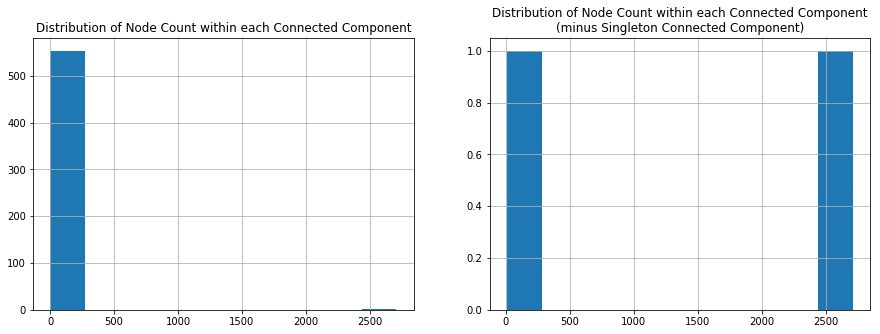

In [12]:
def plotConnectedComponentSizes( graph ):
    """Plots the histogram of the connected component sizes"""
    connected_component_sizes = pd.Series([ len(c) for c in nx.weakly_connected_components( graph ) ])
    ax1, ax2 = plotHistAndFilteredHist( connected_component_sizes, 1 )
    ax1.set_title("Distribution of Node Count within each Connected Component")
    ax2.set_title("Distribution of Node Count within each Connected Component\n(minus Singleton Connected Component)")
plotConnectedComponentSizes( graph )

### So actually most connected components are negligible, single node modules. Somehow there are papers that never cited anyone else, and are never cited. Because they are not Einstein.

### So there is only one or two main connected components in the citation network. (InfoFlow community detection preserves connected components) Out of these one or two, there are around 600 modules that account for 80% of the ergodic frequency. It would be tempting to say these 600 modules are representative of the whole citation network, and the rest are negligible. Can we do that?

### Now let's plot the histograms on modular significances:

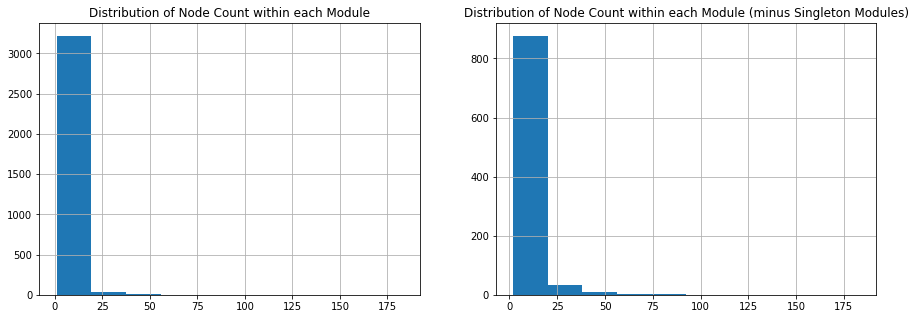

In [13]:
def plotModuleNodeCountHist( nodes ):
    """Plots the histogram of the node count within each module"""
    node_sizes = pd.to_numeric( nodes['count'] )
    ax1, ax2 = plotHistAndFilteredHist( node_sizes, 1 )
    ax1.set_title("Distribution of Node Count within each Module")
    ax2.set_title("Distribution of Node Count within each Module (minus Singleton Modules)")
plotModuleNodeCountHist( nodes )

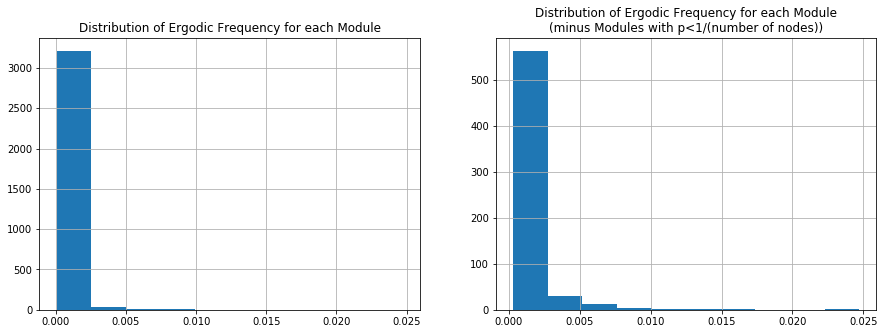

In [14]:
def plotModuleNodeCountHist( nodes ):
    """Plots the histogram of the module size, according to ergodic frequency"""
    node_sizes = pd.to_numeric( nodes['size'] )
    number_of_nodes = node_sizes.count()
    ax1, ax2 = plotHistAndFilteredHist( node_sizes, 1.0/float(number_of_nodes) )
    ax1.set_title("Distribution of Ergodic Frequency for each Module")
    ax2.set_title("Distribution of Ergodic Frequency for each Module\n(minus Modules with p<1/(number of nodes))")
plotModuleNodeCountHist( nodes )

### We see number of modules with high node count and ergodic frequency are very small. How about the node degree, which corresponds to paper citation?

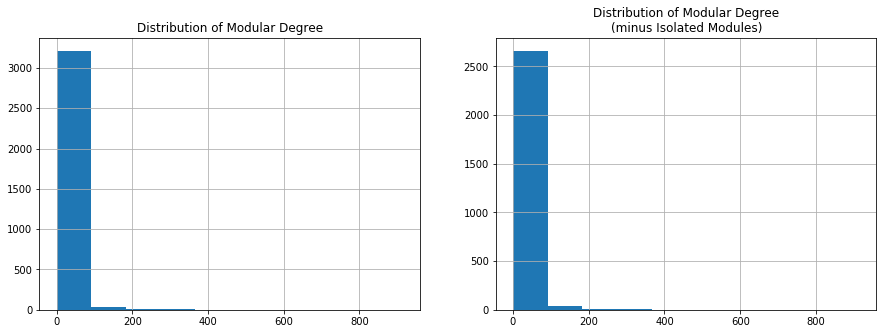

In [15]:
def plotDegree( graph ):
    """Histogram of the modular degree"""
    degrees = pd.Series([ degree[1] for degree in graph.degree ])

    ax1, ax2 = plotHistAndFilteredHist( degrees, 0 )
    return ax1, ax2

def plotAllNodesDegree( graphJS ):
    ax1, ax2 = plotDegree( graphJS )
    ax1.set_title("Distribution of Modular Degree")
    ax2.set_title("Distribution of Modular Degree\n(minus Isolated Modules)")
plotAllNodesDegree( graph )

### Again, most nodes have low degree, representing low citations, while some high citation counts are present, amounting to hundreds.

### What about the connectivities of the insignificant modules?

### Modules with a single node do not cite each other, at all:

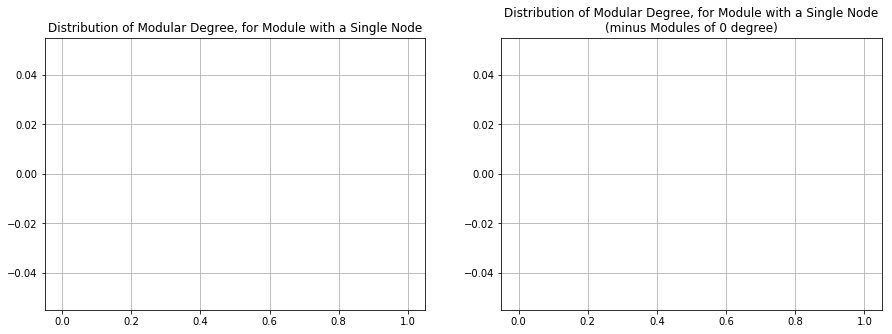

In [16]:
def plotSingletonConnections( graphJS ):
    """Histograms of degree of singleton modules"""
    graph = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )
    sub_nodes = []
    for i in range( len(graphJS['nodes']) ):
        if( int(graphJS['nodes'][i]['count']) == 0 ):
            sub_nodes.append( graphJS['nodes'][i]['name'] )
    filteredGraph = graph.subgraph( sub_nodes )

    ax1, ax2 = plotDegree( filteredGraph )
    ax1.set_title("Distribution of Modular Degree, for Module with a Single Node")
    ax2.set_title("Distribution of Modular Degree, for Module with a Single Node\n(minus Modules of 0 degree)")
plotSingletonConnections( graphJS )

### Modules with small ergodic frequency cite each other sparsely, compared to the total citation histogram above:

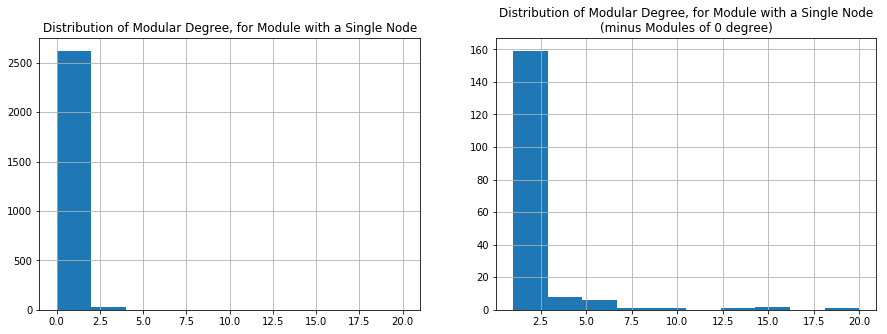

In [17]:
def plotSmallModuleConnections( graphJS ):
    """Histograms of degree of insignificant modules"""
    graph = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )
    node_sizes = pd.to_numeric( nodes['size'] )
    size_threshold = 1.0/len(nodes)
    sub_nodes = []
    for i in range( len(graphJS['nodes']) ):
        if( float(graphJS['nodes'][i]['size']) <= size_threshold ):
            sub_nodes.append( graphJS['nodes'][i]['name'] )
    filteredGraph = graph.subgraph( sub_nodes )

    ax1, ax2 = plotDegree( filteredGraph )
    ax1.set_title("Distribution of Modular Degree, for Module with a Single Node")
    ax2.set_title("Distribution of Modular Degree, for Module with a Single Node\n(minus Modules of 0 degree)")
plotSmallModuleConnections( graphJS )

### Interconnections between significant cells:

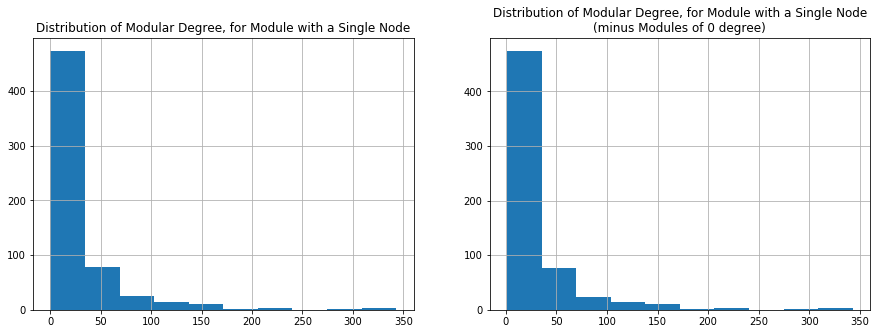

In [18]:
def plotSmallModuleConnections( graphJS ):
    """Histograms of degree of insignificant modules"""
    graph = nx.readwrite.json_graph.node_link_graph( graphJS, directed=True )
    node_sizes = pd.to_numeric( nodes['size'] )
    size_threshold = 1.0/len(nodes)
    sub_nodes = []
    for i in range( len(graphJS['nodes']) ):
        if( float(graphJS['nodes'][i]['count']) > 1 and float(graphJS['nodes'][i]['size']) > size_threshold ):
            sub_nodes.append( graphJS['nodes'][i]['name'] )
    filteredGraph = graph.subgraph( sub_nodes )

    ax1, ax2 = plotDegree( filteredGraph )
    ax1.set_title("Distribution of Modular Degree, for Module with a Single Node")
    ax2.set_title("Distribution of Modular Degree, for Module with a Single Node\n(minus Modules of 0 degree)")
plotSmallModuleConnections( graphJS )

### Comparing these histograms with those in the previous cell, we should see most interconnections are within the significant modules, and between significant modules and insignificant modules.

### Therefore, the significant modules accounts for the ergodic frequency and connections, forming the backbond of the network. The insigificant modules can be neglected when considering the network structure.

### This makes sense, since a module is characterized by random walk staying within the module for long time, so that a module with small ergodic frequency is a relatively isolated, insignificant module. Such a module is by definition unlikely to be a major connection between major hubs.

## InfoMap and InfoFlow therefore finds communities based on information flow. The communities can further be categorized as significant and insignificant modules, where the significant modules form the backbone of the network.